In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.optimizers import Adam

In [2]:
# 랜덤 시드 설정 (항상 동일한 변형이 적용되도록)
np.random.seed(12345)
tf.random.set_seed(12345)

In [3]:
# 사용자 정의 증강 함수 (이미지 5가지 중 하나를 선택하여 적용)
def custom_augmentation(image):
    augmentation_type = np.random.choice(["rotation", "zoom", "shear", "crop", "horizontal_flip"])
    
    if augmentation_type == "rotation":
        angles = [45, 90, 135, 180, 225, 270, 315]
        angle = np.random.choice(angles)
        image = tf.keras.preprocessing.image.random_rotation(image, angle)
    
    elif augmentation_type == "zoom":
        image = tf.keras.preprocessing.image.random_zoom(image, (0.8, 1.2), fill_mode='nearest')
    
    elif augmentation_type == "shear":
        image = tf.keras.preprocessing.image.random_shear(image, 0.2, fill_mode='nearest')
    
    elif augmentation_type == "crop":
        image = tf.keras.preprocessing.image.random_shift(image, 0.2, 0.2, fill_mode='nearest')
    
    elif augmentation_type == "horizontal_flip":
        image = tf.image.flip_left_right(image)
    
    return image

In [4]:
# 원본 데이터를 사용한 ImageDataGenerator (변형 없이 사용)
original_datagen = ImageDataGenerator(
    rescale=1./255  # 정규화만 적용
)

# 변형된 이미지를 추가하기 위한 ImageDataGenerator
augmented_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=custom_augmentation  # 사용자 정의 증강 함수 적용
)

# 검증 데이터는 따로 경로에서 불러오되, 배치 단위로 불러오고 정규화하기 위해 생성기 사용
validation_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
# 경로에서 데이터를 불러옴
train_data_dir = "data/horse-or-human/train"
validation_data_dir = "data/horse-or-human/validation"
img_size = (224, 224)

In [6]:
# 배치 크기를 32로 설정
batch_size = 32

# 원본 이미지 생성기
original_generator = original_datagen.flow_from_directory(
    train_data_dir,
    target_size=img_size,
    batch_size=batch_size,  # 원본 데이터 배치 크기 설정
    class_mode='binary'
)

# 변형된 이미지 생성기
augmented_generator = augmented_datagen.flow_from_directory(
    train_data_dir,
    target_size=img_size,
    batch_size=batch_size,  # 변형된 데이터 배치 크기 설정
    class_mode='binary'
)

# 검증 데이터 생성기 (경로에서 불러오면서 정규화 및 배치 처리)
validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

Found 1027 images belonging to 2 classes.
Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [7]:
# DenseNet 모델 불러오기 (사전 학습된 가중치 사용)
base_model = DenseNet121(
    weights="imagenet", include_top=False, input_shape=(224, 224, 3)
)

In [8]:
# 모델 구성
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation="sigmoid"))


In [9]:
# 사전 학습된 층은 훈련되지 않도록 설정
for layer in base_model.layers:
    layer.trainable = False

In [10]:

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.00001), loss="binary_crossentropy", metrics=["accuracy"])

In [11]:
# 두 개의 데이터 제너레이터를 합치는 함수 (원본 배치 + 변형된 배치)
def combined_generator(original_gen, augmented_gen):
    while True:
        original_data = next(original_gen)
        augmented_data = next(augmented_gen)
        combined_data = np.concatenate([original_data[0], augmented_data[0]], axis=0)
        combined_labels = np.concatenate([original_data[1], augmented_data[1]], axis=0)
        yield combined_data, combined_labels

In [12]:
# 모델 학습 (작은 배치 크기 사용)
history = model.fit(
    combined_generator(original_generator, augmented_generator),
    steps_per_epoch=len(original_generator),  # 배치 크기에 맞춘 steps_per_epoch
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=10,  # 총 10 에포크 학습
    verbose=1
)

Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7784 - loss: 0.4720

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.7821 - loss: 0.4642 - val_accuracy: 1.0000 - val_loss: 0.0036
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.9703 - loss: 0.0616
Epoch 3/10


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


33/33 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.9764 - loss: 0.0446 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.9880 - loss: 0.0362
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.9814 - loss: 0.0395 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.9832 - loss: 0.0344
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.9843 - loss: 0.0347 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.9830 - loss: 0.0399
Epoch 9/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.9827 - loss: 0.0355 - val_accuracy: 1.0000 - val_loss: 9.2764e-04
Epoch 10/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.9898 - loss: 0.0250


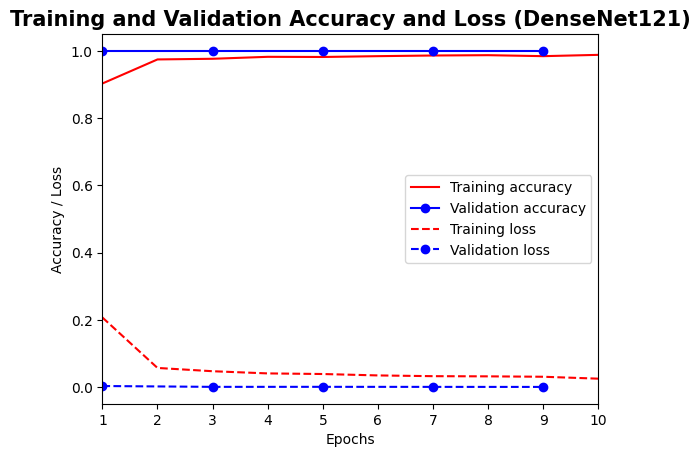

In [16]:
import matplotlib.pyplot as plt

# 학습 결과 시각화
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(len(acc))

# 전체 에포크 수
num_epochs = 10

# 정확도 및 손실 데이터 길이 확인
acc_len = len(history.history['accuracy'])
val_acc_len = len(history.history['val_accuracy'])
loss_len = len(history.history['loss'])
val_loss_len = len(history.history['val_loss'])

# 에포크 범위 설정
epochs = range(1, num_epochs + 1)  # x축을 1부터 num_epochs까지 설정

# 정확도 시각화
plt.plot(epochs, acc[:num_epochs], "r", label="Training accuracy")
# Validation accuracy: 홀수 에포크에서만 표시
plt.plot(
    [i for i in range(1, num_epochs + 1) if i % 2 == 1], 
    val_acc, 
    "b", 
    label="Validation accuracy", 
    marker='o'
)

# 손실 시각화
plt.plot(epochs, loss[:num_epochs], "r--", label="Training loss")
# Validation loss: 홀수 에포크에서만 표시
plt.plot(
    [i for i in range(1, num_epochs + 1) if i % 2 == 1], 
    val_loss, 
    "b--", 
    label="Validation loss", 
    marker='o'
)

# 그래프 제목 및 레이블 설정
plt.title("Training and Validation Accuracy and Loss (DenseNet121)", fontsize='15', fontweight='bold')
plt.xlabel("Epochs", fontsize='10')
plt.ylabel("Accuracy / Loss", fontsize='10')
plt.legend()

# x축 범위 설정
plt.xlim(1, num_epochs)  # x축 범위를 1에서 num_epochs까지 설정
# plt.ylim(0,1)
# 그래프 표시
plt.show()


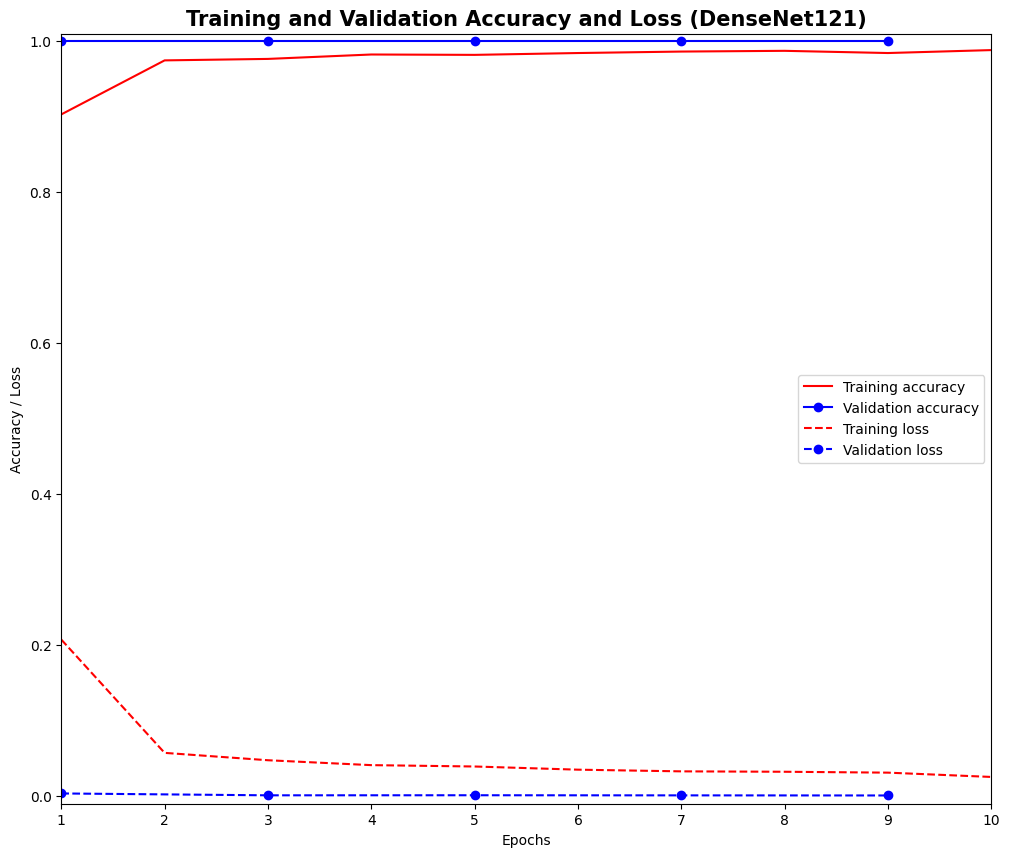

In [22]:
# 학습 결과 시각화
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(len(acc))
num_epochs = 10
# 에포크 범위 설정
plt.figure(figsize=(12,10))
epochs = range(1, num_epochs + 1)  # x축을 1부터 num_epochs까지 설정
# 정확도 시각화
plt.plot(epochs, acc[:num_epochs], "r", label="Training accuracy")
plt.plot(
    [i for i in range(1, num_epochs + 1) if i % 2 == 1],  # x축도 홀수 에포크
    val_acc,  # y축: 검증 정확도
    "b",
    label="Validation accuracy",
    marker='o'
)
# 손실 시각화
plt.plot(epochs, loss[:num_epochs], "r--", label="Training loss")
# Validation loss: 홀수 에포크에서만 표시
plt.plot(
    [i for i in range(1, num_epochs + 1) if i % 2 == 1],  # x축도 홀수 에포크
    val_loss,  # y축: 검증 손실
    "b--",
    label="Validation loss",
    marker='o'
)
# 그래프 제목 및 레이블 설정
plt.title("Training and Validation Accuracy and Loss (DenseNet121)", fontsize='15', fontweight='bold')
plt.xlabel("Epochs", fontsize='10')
plt.ylabel("Accuracy / Loss", fontsize='10')
plt.legend()
# x축 범위 설정
plt.xlim(1, num_epochs)  # x축 범위를 1에서 num_epochs까지 설정
plt.ylim(-0.01,1.01)
# 그래프 표시
plt.show()

In [17]:
# 모델 저장
model.save('DenseNet121_수정.keras')